## SVM Binary Toxic Classifier - Balanced learning

In [273]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from imblearn.under_sampling import RandomUnderSampler
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import SVC, LinearSVC
from sklearn.model_selection import GridSearchCV
from sklearn.feature_extraction.text import CountVectorizer, TfidfTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import confusion_matrix, classification_report

In [274]:
# utility function
def make_confusion_matrix( cfm, title):
    group_names = ['TN','FP','FN','TP']

    group_counts = ["{0:0.0f}".format(value) for value in
                cfm.flatten()]

    group_percentages = ["{0:.2%}".format(value) for value in
                     cfm.flatten()/np.sum(cfm)]

    labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]

    labels = np.asarray(labels).reshape(2,2)
    plt.title(title)
    
    sns.heatmap(cfm, annot=labels, fmt="", cmap='Blues')
    plt.ylabel('True Label', fontsize=12)
    plt.xlabel('Predicted',fontsize=12)

In [275]:
from sklearn.metrics import roc_curve,auc

def plot_roc_curve(y_test, prediction, name_model):
    test_fpr, test_tpr, te_thresholds = roc_curve(y_test, prediction)

    plt.grid()
    auc_score = round(auc(test_fpr, test_tpr),2)
    plt.plot(test_fpr, test_tpr, label=f"{name_model} - AUC ="+ str(auc_score))
    plt.plot([0,1],[0,1],'r--')
    plt.legend()
    plt.xlabel("True Positive Rate")
    plt.ylabel("False Positive Rate")
    plt.title(f" AUC(ROC curve) - {name_model}")
    plt.grid(color='black', linestyle='', linewidth=0.5)
    plt.show()

In [276]:
df = pd.read_csv('data/final.zip', compression='zip')
data = 'tokenized_stemmed'
target = 'TOXIC'

In [277]:
df.head()

,Unnamed: 0,id,comment_text,toxic,severe_toxic,obscene,threat,insult,identity_hate,TOXIC,...,word_counts,unique_word_counts,clean_text,tokenized,tokenized_no_stopwords,tokenized_stemmed,tokenized_pos,tokenized_lemmatized,tokenized_lemmatized_pos,tokenized_bigram
0,0,0000997932d777bf,Explanation\nWhy the edits made under my usern...,0,0,0,0,0,0,0,...,43,41,explanation why the edits made under my userna...,"['explanation', 'why', 'the', 'edits', 'made',...","['explanation', 'edits', 'made', 'username', '...","['explan', 'edit', 'made', 'usernam', 'hardcor...","[('explanation', 'NN'), ('edits', 'NNS'), ('ma...","['explanation', 'edits', 'made', 'username', '...","['explanation', 'edits', 'make', 'username', '...","[('explanation', 'edits'), ('edits', 'made'), ..."
1,1,000103f0d9cfb60f,D'aww! He matches this background colour I'm s...,0,0,0,0,0,0,0,...,17,17,daww he matches this background colour i am se...,"['daww', 'he', 'matches', 'this', 'background'...","['daww', 'matches', 'background', 'colour', 's...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'NN'), ('matches', 'NNS'), ('backgro...","['daww', 'match', 'background', 'colour', 'see...","['daww', 'match', 'background', 'colour', 'see...","[('daww', 'matches'), ('matches', 'background'..."
2,2,000113f07ec002fd,"Hey man, I'm really not trying to edit war. It...",0,0,0,0,0,0,0,...,42,39,hey man i am really not trying to edit war it ...,"['hey', 'man', 'i', 'am', 'really', 'not', 'tr...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'realli', 'tri', 'edit', 'war',...","[('hey', 'NN'), ('man', 'NN'), ('really', 'RB'...","['hey', 'man', 'really', 'trying', 'edit', 'wa...","['hey', 'man', 'really', 'try', 'edit', 'war',...","[('hey', 'man'), ('man', 'really'), ('really',..."
3,3,0001b41b1c6bb37e,"""\nMore\nI can't make any real suggestions on ...",0,0,0,0,0,0,0,...,113,82,more i cannot make any real suggestions on im...,"['more', 'i', 'can', 'not', 'make', 'any', 're...","['make', 'real', 'suggestions', 'improvement',...","['make', 'real', 'suggest', 'improv', 'wonder'...","[('make', 'VB'), ('real', 'JJ'), ('suggestions...","['make', 'real', 'suggestion', 'improvement', ...","['make', 'real', 'suggestion', 'improvement', ...","[('make', 'real'), ('real', 'suggestions'), ('..."
4,4,0001d958c54c6e35,"You, sir, are my hero. Any chance you remember...",0,0,0,0,0,0,0,...,13,13,you sir are my hero any chance you remember wh...,"['you', 'sir', 'are', 'my', 'hero', 'any', 'ch...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chanc', 'rememb', 'page']","[('sir', 'NN'), ('hero', 'NN'), ('chance', 'NN...","['sir', 'hero', 'chance', 'remember', 'page']","['sir', 'hero', 'chance', 'remember', 'page']","[('sir', 'hero'), ('hero', 'chance'), ('chance..."


### Unbalanced classes

Text(0.5, 1.0, 'Unbalanced Labels')

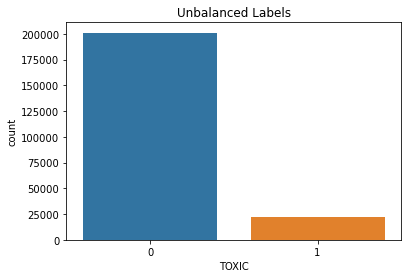

In [278]:
sns.countplot(data=df, x=target)
plt.title("Unbalanced Labels")

In [279]:
print('Legend:\n0: No Toxic\n1: Toxic\n')
df[target].value_counts()

Legend:
0: No Toxic
1: Toxic



0    201081
1     22468
Name: TOXIC, dtype: int64

### Random Undersampling

In [280]:
labels = df[[target]]
df.drop(target,axis=1,inplace=True)

In [216]:
under_sample = RandomUnderSampler(random_state=42)
data_under, labels_under = under_sample.fit_resample(df,labels)

<AxesSubplot:xlabel='TOXIC', ylabel='count'>

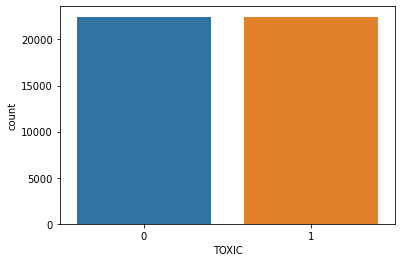

In [281]:
sns.countplot(data=labels_under, x=target)

In [218]:
print('Legend:\n0: No Toxic\n1: Toxic\n')
labels_under.value_counts()

Legend:
0: No Toxic
1: Toxic



TOXIC
0        22468
1        22468
dtype: int64

### Split Data

In [282]:
X_train, X_test, y_train, y_test = train_test_split(data_under[data], labels_under[target], test_size=0.30, random_state=42, stratify=labels_under) 

In [283]:
print(f"Training set\n{y_train.value_counts()}\n")
print(f"Test set\n{y_test.value_counts()}\n")

Training set
1    15728
0    15727
Name: TOXIC, dtype: int64

Test set
0    6741
1    6740
Name: TOXIC, dtype: int64



## Support Vector Machine Classifiers - Hard Margin

In [228]:
#help(LinearSVC)

In [256]:
lsvc_pipeline = Pipeline([
    ('vect', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('clf-svc', LinearSVC(class_weight='balanced', verbose=1, random_state=42))])

lsvc_pipeline.fit(X_train,y_train)

[LibLinear]

Pipeline(steps=[('vect', CountVectorizer()), ('tfidf', TfidfTransformer()),
                ('clf-svc',
                 LinearSVC(class_weight='balanced', random_state=42,
                           verbose=1))])

In [257]:
y_pred = lsvc_pipeline.predict(X_test)
print(classification_report(y_test,y_pred ))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6741
           1       0.90      0.88      0.89      6740

    accuracy                           0.89     13481
   macro avg       0.89      0.89      0.89     13481
weighted avg       0.89      0.89      0.89     13481



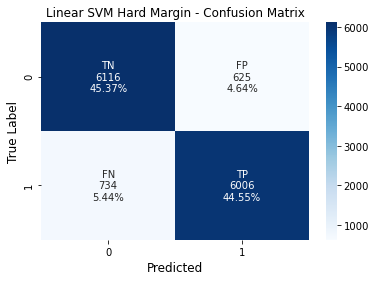

In [284]:
cf_matrix = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix, 'Linear SVM Hard Margin - Confusion Matrix')

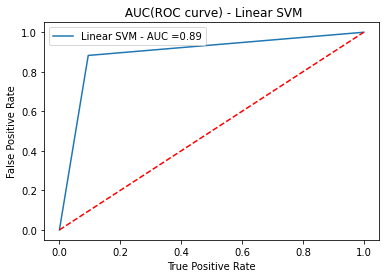

In [259]:
plot_roc_curve(y_test, y_pred, 'Linear SVM')

### SVM: Coarse GridSearch

In [260]:
lsvc_pipeline = Pipeline([
    ('vect', CountVectorizer()),  
    ('tfidf', TfidfTransformer()),  
    ('clf-svc', LinearSVC(class_weight='balanced', verbose=1, random_state=42))])

In [261]:
params = {'vect__ngram_range': [(1, 1), (1, 2)],
          'tfidf__use_idf': (True, False),
          'clf-svc__C': [0.2, 0.5, 1, 2, 3, 5, 10, 100],
         }

In [262]:
gs = GridSearchCV(estimator=lsvc_pipeline, param_grid=params, n_jobs=-1, cv=3)
gs_results = gs.fit(X_train, y_train)

[LibLinear]

In [263]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf-svc__C': 1, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
accuracy: 0.8951518041646797


### SVM: Fine GrideSearch

In [264]:
# Fine Random search for C parameter in Linear SVM
params = {'vect__ngram_range': [(1, 1), (1, 2), (1,3)],
          'tfidf__use_idf': (True, False),
          'clf-svc__C': list(np.arange(0.5,1.5,0.05)),
         }

In [265]:
gs = GridSearchCV(estimator=lsvc_pipeline, param_grid=params, n_jobs=-1, cv=3)
gs_results = gs.fit(X_train, y_train)

[LibLinear]

In [266]:
print(f"best parameters:\n{gs_results.best_params_}\naccuracy: {gs_results.best_score_}")

best parameters:
{'clf-svc__C': 0.9000000000000004, 'tfidf__use_idf': False, 'vect__ngram_range': (1, 2)}
accuracy: 0.8954379271975839


### Retrain and test the model

In [267]:
lsvc_pipeline = Pipeline([
    ('vect', CountVectorizer(ngram_range=(1, 2))),  
    ('tfidf', TfidfTransformer(use_idf=False)),  
    ('clf-svc', LinearSVC(C=0.9000000000000004 ,class_weight='balanced', verbose=1, random_state=42))])

In [268]:
lsvc_pipeline.fit(X_train,y_train)

[LibLinear]

Pipeline(steps=[('vect', CountVectorizer(ngram_range=(1, 2))),
                ('tfidf', TfidfTransformer(use_idf=False)),
                ('clf-svc',
                 LinearSVC(C=0.9000000000000004, class_weight='balanced',
                           random_state=42, verbose=1))])

In [269]:
y_pred = lsvc_pipeline.predict(X_test)
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.89      0.91      0.90      6741
           1       0.91      0.89      0.90      6740

    accuracy                           0.90     13481
   macro avg       0.90      0.90      0.90     13481
weighted avg       0.90      0.90      0.90     13481



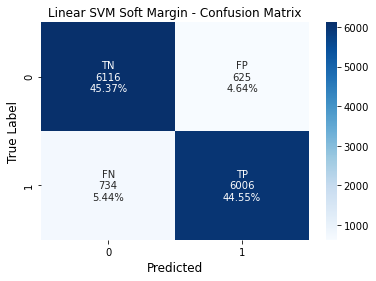

In [270]:
cf_matrix_soft = confusion_matrix(y_test, y_pred)
make_confusion_matrix(cf_matrix_soft, 'Linear SVM Soft Margin - Confusion Matrix')

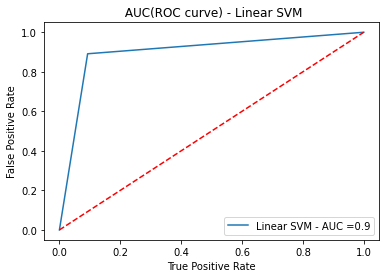

In [271]:
plot_roc_curve(y_test, y_pred, 'Linear SVM')